## Proximity Learning with CatBoost

This Python code trains a **CatBoost regression model** and computes **instance similarity** based on **proximity learning**. The similarity between two instances is determined by how frequently they appear in the same **leaf node** across trees, with an additional weight based on **tree importance**.

---

## Similarity Computation

We use **Equation (2)** and **Equation (3)** to compute instance similarity.

### Equation (2): Instance Similarity Score

$$
P(i,j) = \frac{1}{N} \sum_{t=1}^{N} \Delta_t \cdot I_t(v(j) = v(i))
$$

where:
- \( N \) is the **total number of trees**.
- \( I_t(v(j) = v(i)) \) is **1 if two instances share a leaf** in tree \( t \), otherwise **0**.
- \( \Delta_t \) is the **importance of tree** \( t \), computed as:

### Equation (3): Tree Importance

$$
\Delta_t = \frac{E(t) - E(t-1)}{\sum_{t=1}^{N} (E(t) - E(t-1))}
$$

where:
- \( E(t) \) is the **error of the model** after tree \( t \).
- The difference \( E(t) - E(t-1) \) measures the **impact of tree \( t \) in reducing error**.

---

## Intuition

- **Instance similarity** is based on **how often instances appear in the same leaf** across trees.
- Trees with **higher importance** (greater error reduction) **contribute more** to the similarity score.
- This approach captures **local relationships** rather than relying on global distance metrics.

This method enhances **interpretability** and **clustering** in machine learning models by leveraging the structure of **gradient boosting decision trees** (GBDTs) like CatBoost.

---

## Step 1: Import Necessary Libraries

In [337]:
import numpy as np
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, roc_auc_score

## Step 2: Loading and Processing Data from AdBench

In [340]:
# List of datasets to use
datasets = ['2_annthyroid', '5_campaign', '39_vertebral','11_donors','12_fault','18_Ionosphere', '24_mnist','30_satellite','33_skin']

def load_dataset(dataset):
    path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
    data = np.load(path, allow_pickle=True)
    return data['X'], data['y']


## Step 3: Defining Function to Train CatBoost and Compute Similarity

In [343]:
def compute_similarity(X, y, active_learning_fraction=0.2, query_strategy='clusters'):
    # Ensure stratified split to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    n_labeled = int(active_learning_fraction * len(X_train))
    
    # Ensure label diversity
    unique_labels = np.unique(y_train)
    if len(unique_labels) == 1:
        raise ValueError("Training set has only one unique target value. Adjust sampling method.")
    
    # Active Learning: Query Strategy - Clusters
    kmeans = KMeans(n_clusters=n_labeled, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train)
    
    # Select representative points for labeling
    selected_indices = []
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices.append(cluster_indices[0])  # Pick first point in each cluster
    
    X_labeled, y_labeled = X_train[selected_indices], y_train[selected_indices]
    X_unlabeled, y_unlabeled = np.delete(X_train, selected_indices, axis=0), np.delete(y_train, selected_indices, axis=0)
    
    # Train CatBoost Regressor on labeled data
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
    model.fit(X_labeled, y_labeled)
    
    # Predict labels for the unlabeled dataset using the trained model
    y_unlabeled = model.predict(X_unlabeled)
    
    # Retrain model with expanded labeled dataset
    X_labeled = np.vstack((X_labeled, X_unlabeled))
    y_labeled = np.hstack((y_labeled, y_unlabeled))
    #model.fit(X_labeled, y_labeled)
    
    # Evaluate model performance using AUC, ensuring multiple classes exist
    y_test_preds = model.predict(X_test)
    if len(np.unique(y_test)) > 1:
        auc_score = roc_auc_score(y_test, y_test_preds)
        print(f"Model AUC Score: {auc_score:.4f}")
    else:
        print("Skipping AUC calculation: y_test contains only one class.")
    
    # Get leaf indices for each instance
    leaf_indices_train = model.calc_leaf_indexes(X_labeled)
    
    # Compute errors for tree importance
    train_preds = model.predict(X_labeled)
    errors = np.square(train_preds - y_labeled)
    
    tree_errors = [
        mean_squared_error(y_labeled, np.array(list(model.staged_predict(X_labeled, ntree_end=i))[-1]))
        for i in range(1, model.tree_count_ + 1)
    ]
    
    tree_errors = np.array(tree_errors)
    
    # Compute tree importance
    delta_t = np.diff(tree_errors, prepend=0)
    delta_t = np.abs(delta_t)
    delta_t /= np.sum(delta_t)
    
    # Compute similarity scores
    num_trees = model.tree_count_
    similarity_matrix = np.zeros((len(X_labeled), len(X_labeled)))
    
    for t in range(num_trees):
        leaf_assignments = leaf_indices_train[:, t]
        for i in range(len(X_labeled)):
            for j in range(len(X_labeled)):
                if leaf_assignments[i] == leaf_assignments[j]:
                    similarity_matrix[i, j] += delta_t[t]
    
    similarity_matrix /= num_trees
    
    # Ensure all values are positive using Min-Max scaling
    scaler = MinMaxScaler()
    similarity_matrix = scaler.fit_transform(similarity_matrix)
    
    return similarity_matrix, model


## Step 4: Training Model and Computing Similarity for Each Dataset

In [346]:
results = {}
for dataset in datasets:
    print(f'Processing {dataset}...')
    X, y = load_dataset(dataset)
    
    # Sub-sample 1000 instances (or full dataset if smaller)
    sample_size = min(100, len(X))  # Ensure we don't exceed dataset size
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample, y_sample = X[indices], y[indices]
    
    # Compute similarity
    similarity_matrix, model = compute_similarity(X_sample, y_sample)
    results[dataset] = {'similarity_matrix': similarity_matrix, 'model': model}

Processing 2_annthyroid...
Model AUC Score: 0.8421
Processing 5_campaign...
Model AUC Score: 0.9216
Processing 39_vertebral...
Model AUC Score: 0.6863
Processing 11_donors...
Model AUC Score: 1.0000
Processing 12_fault...
Model AUC Score: 0.3125
Processing 18_Ionosphere...
Model AUC Score: 0.7802
Processing 24_mnist...
Model AUC Score: 0.5833
Processing 30_satellite...
Model AUC Score: 0.7619
Processing 33_skin...
Model AUC Score: 1.0000


## Step 5: Plotting Similarity Heatmaps

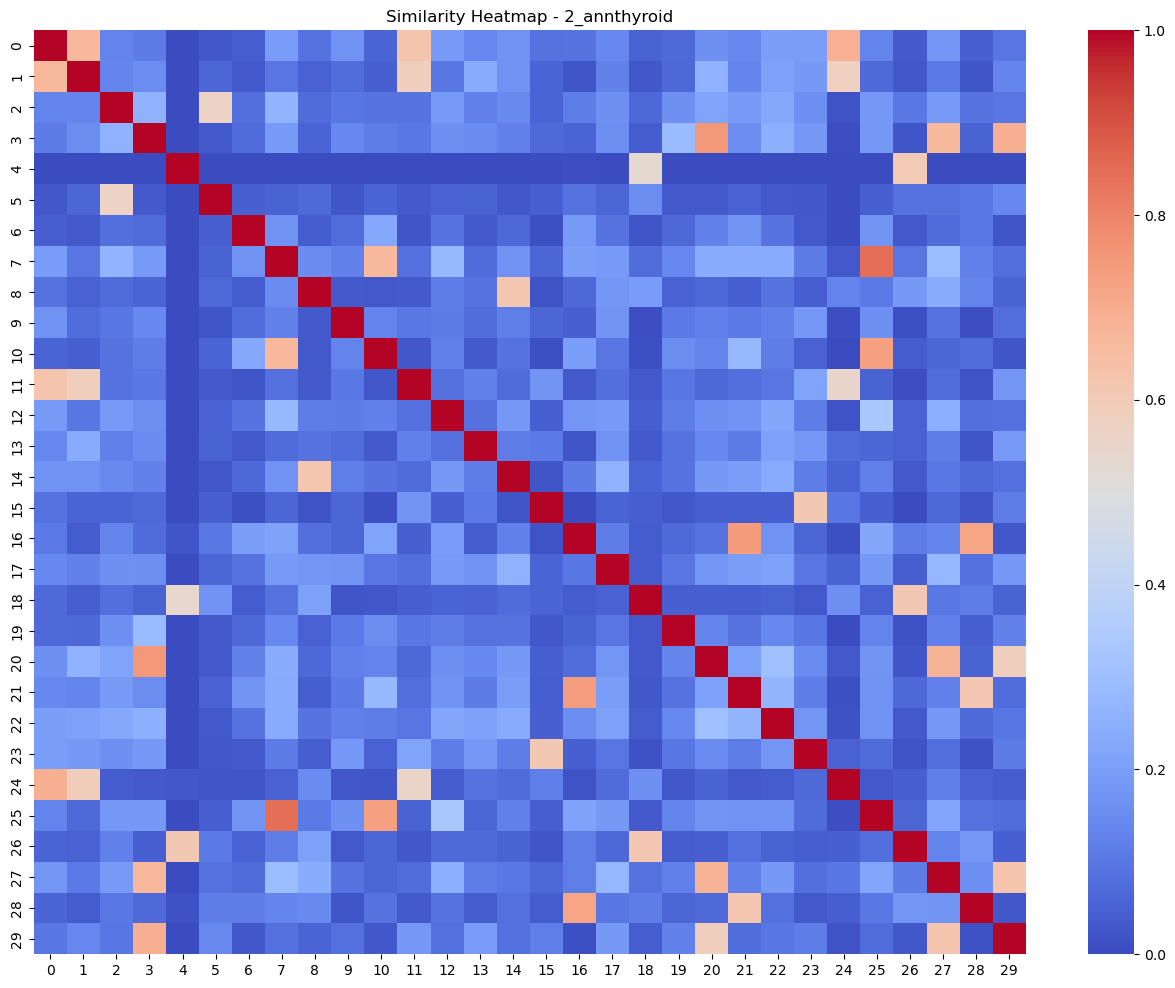

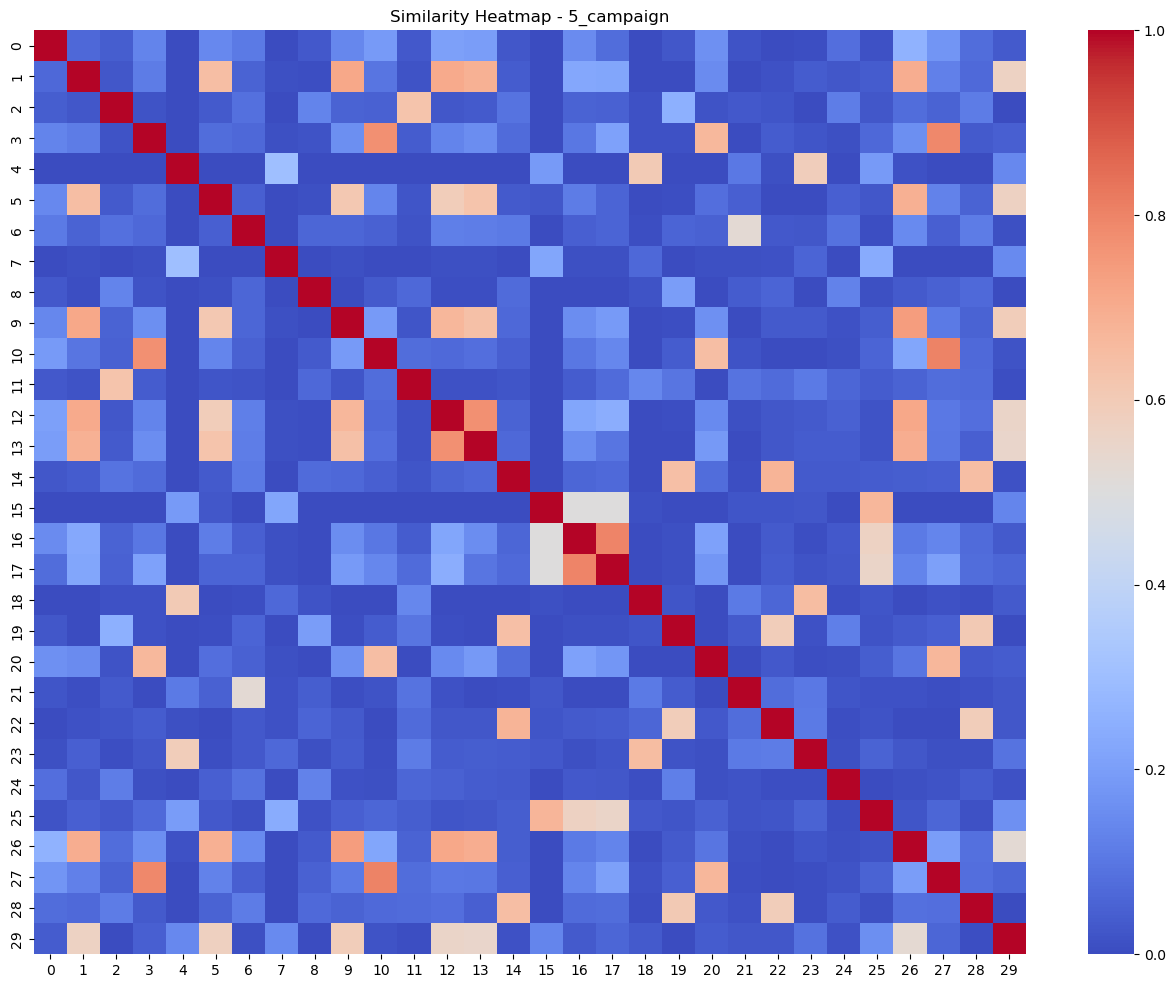

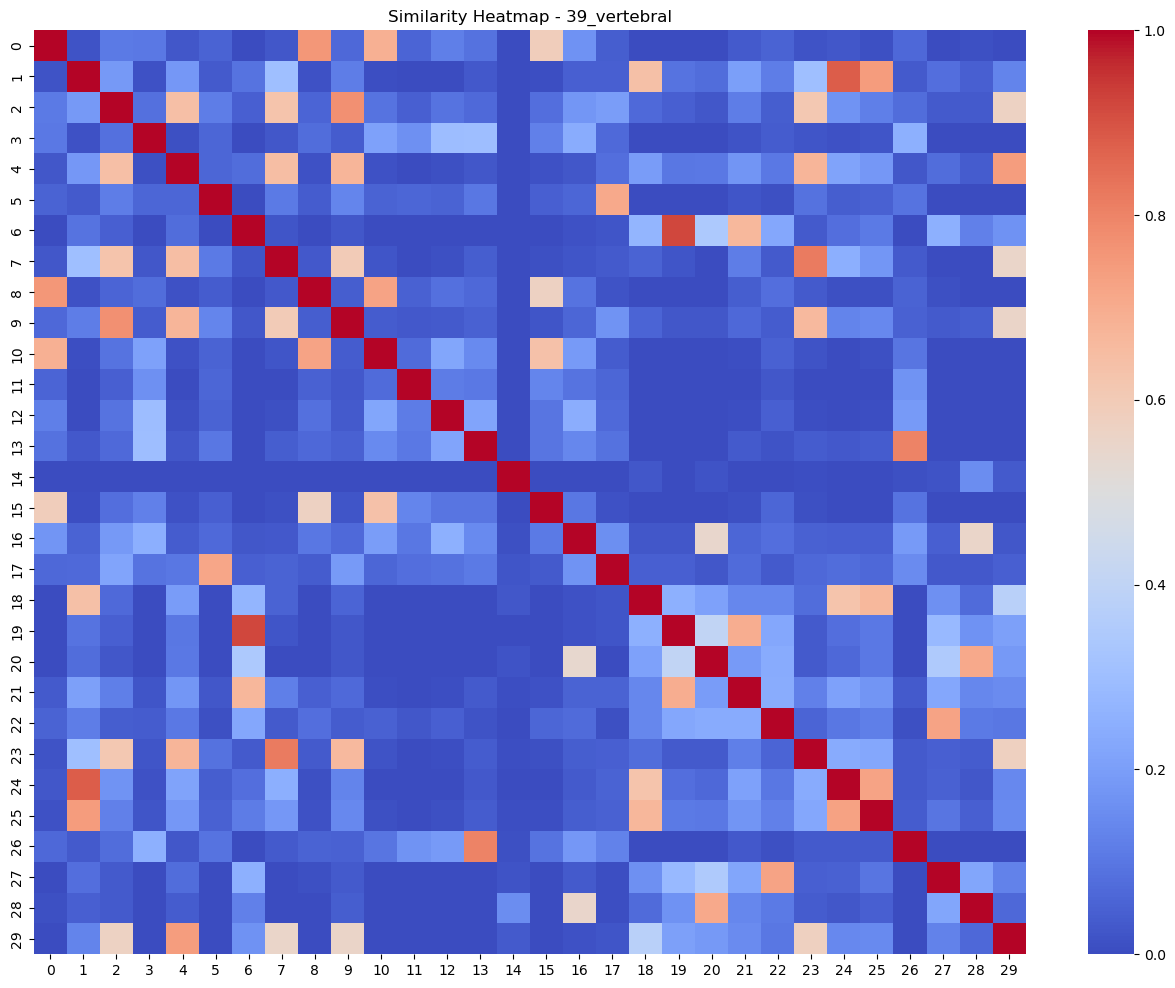

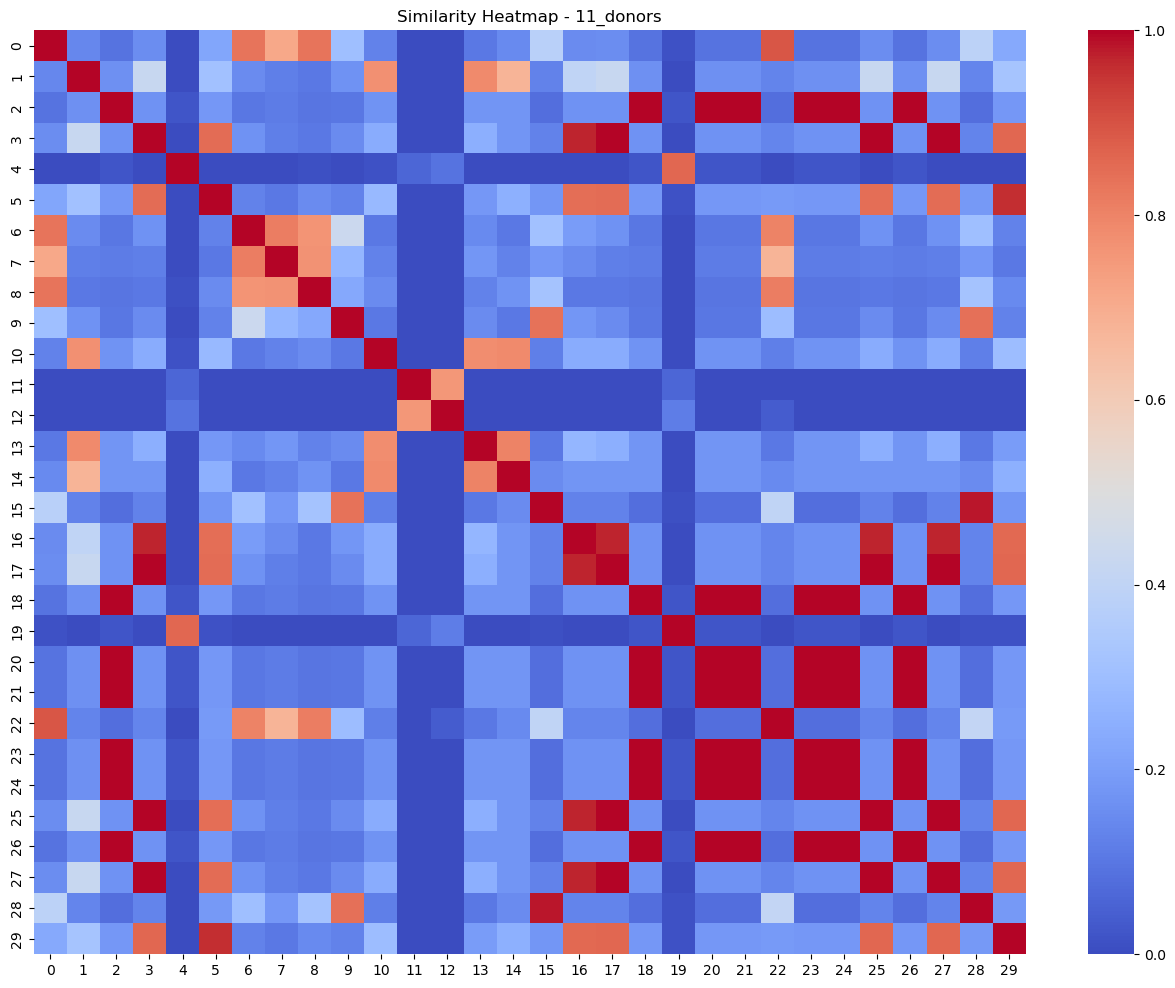

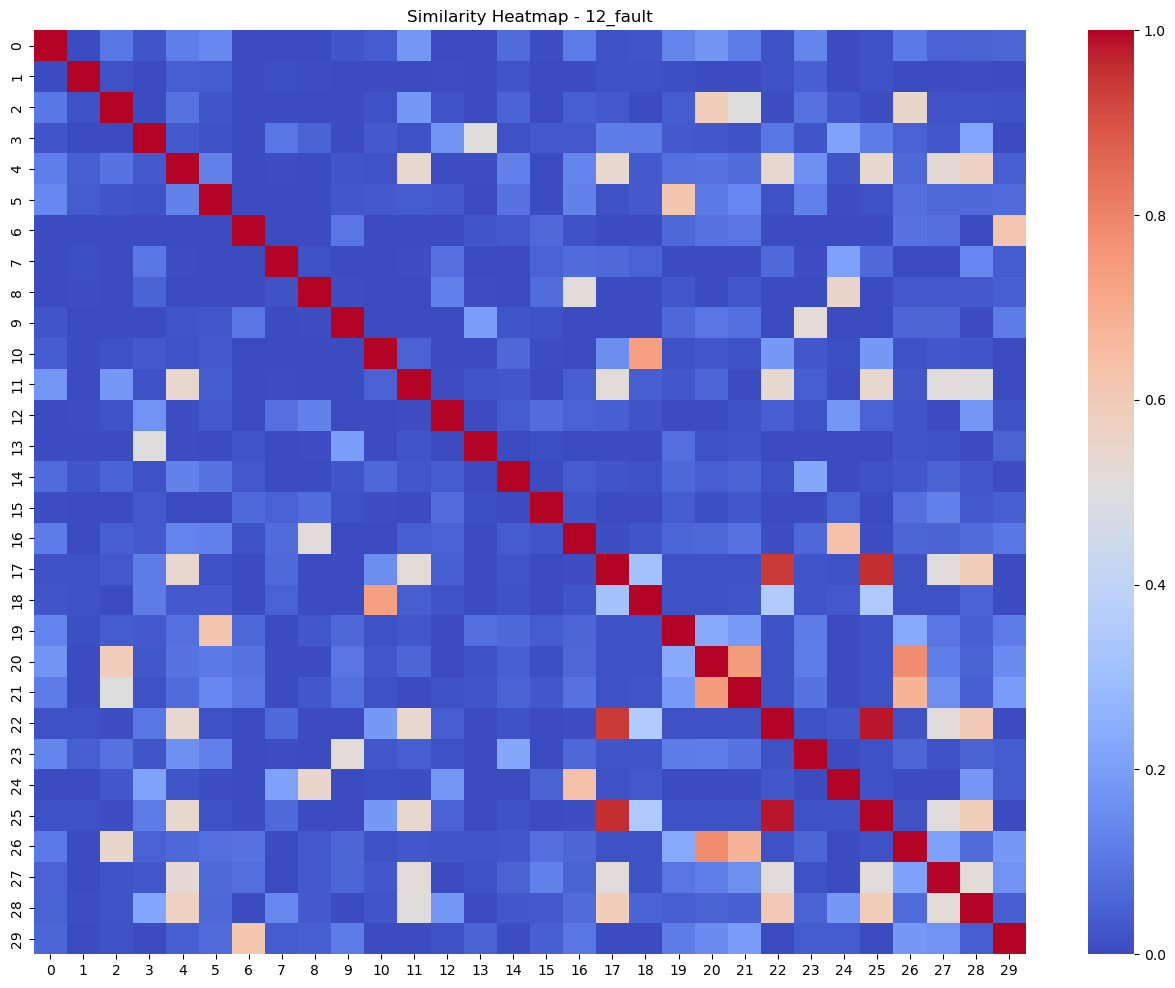

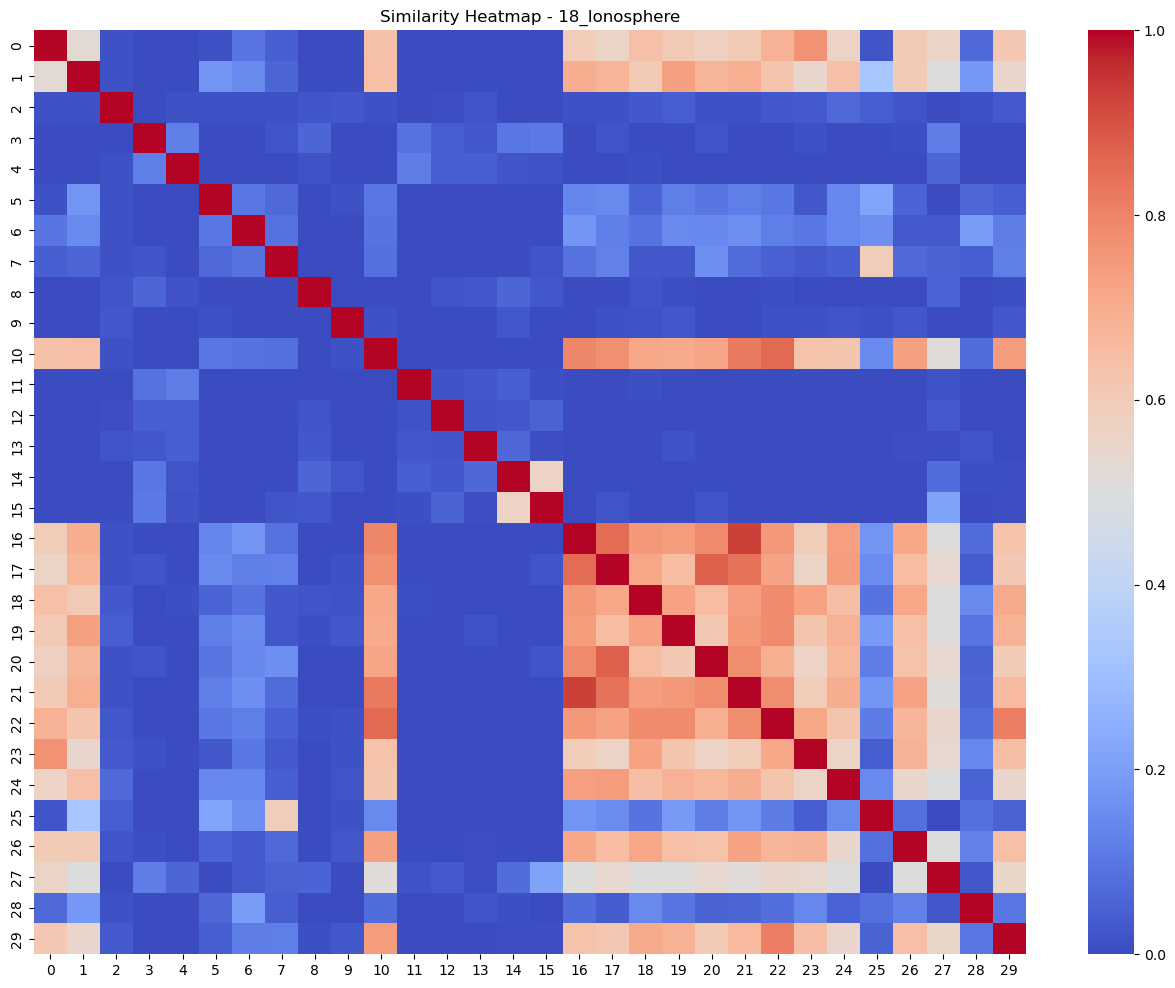

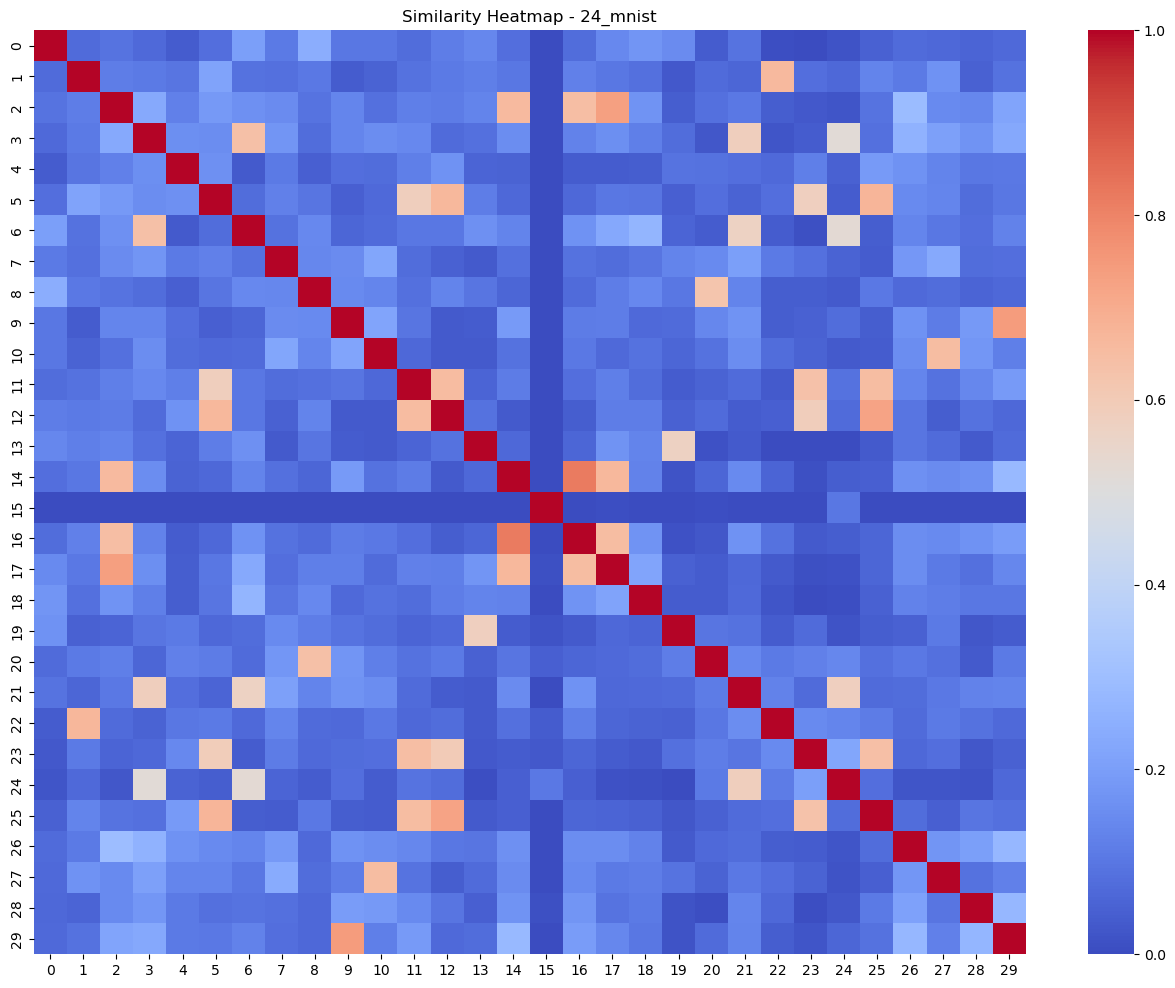

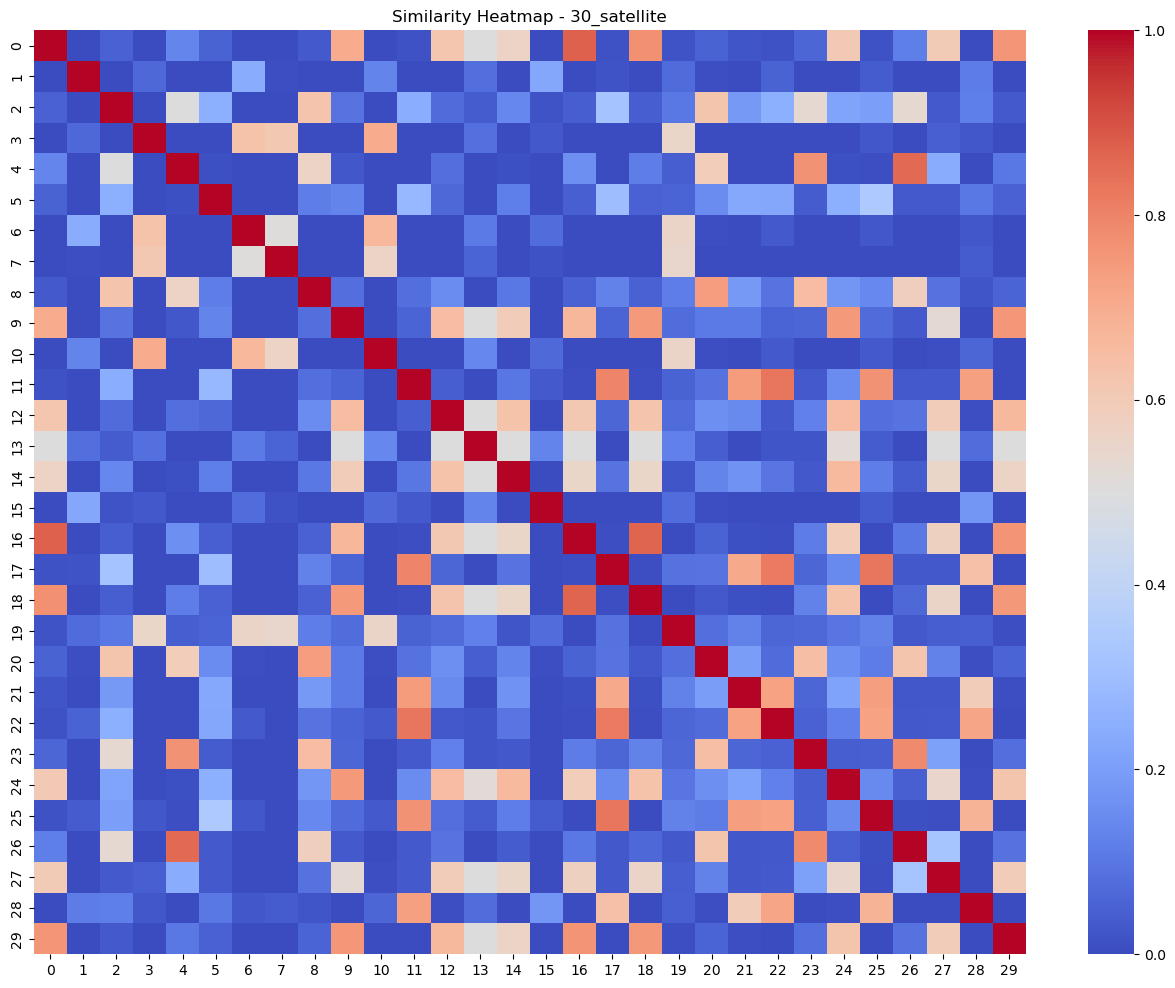

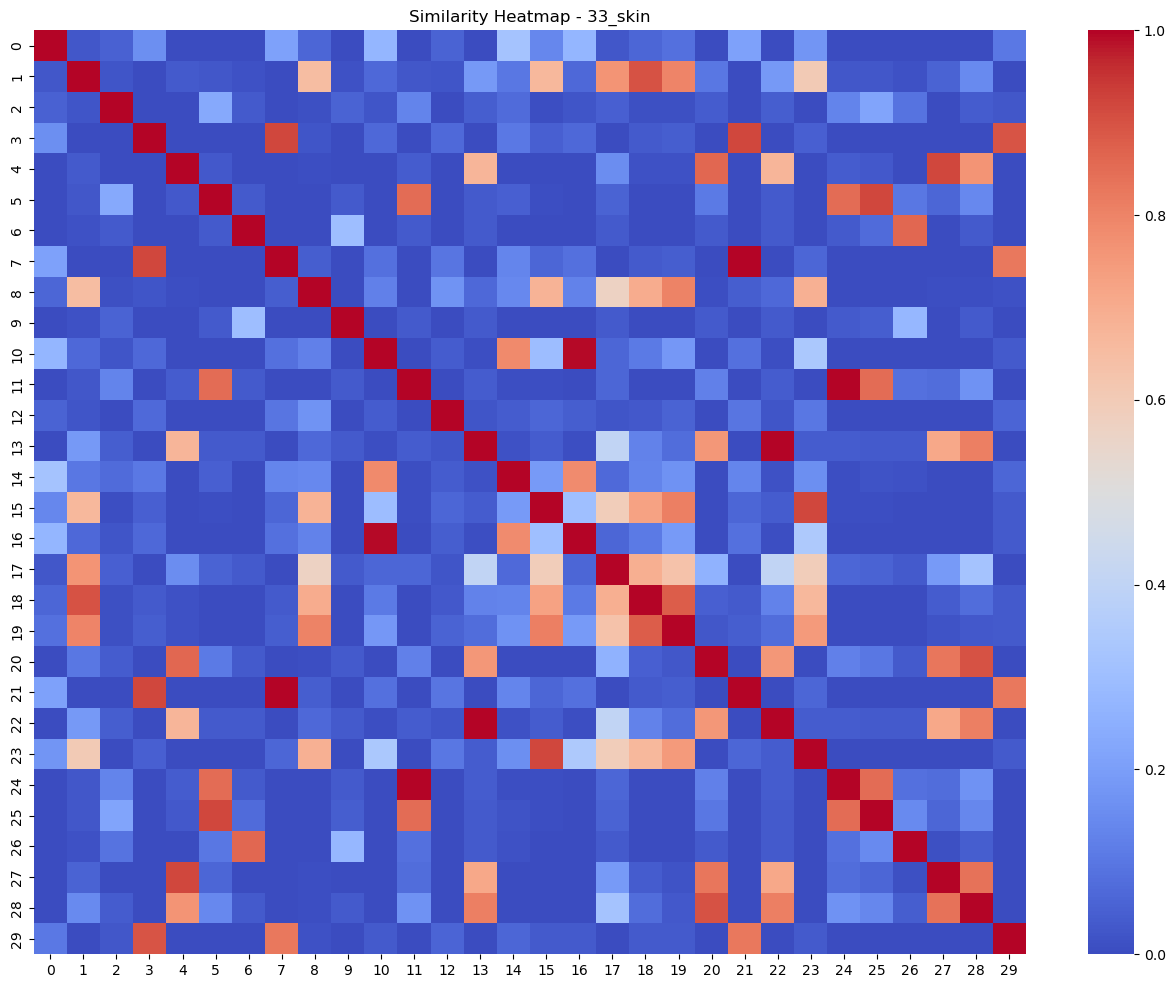

In [348]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(16, 12))
    sns.heatmap(similarity_matrix[:30, :30], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

for i in datasets:
    plot_similarity(results[i]['similarity_matrix'], i)

In [349]:
import pandas as pd

def display_similarity_dataframe(dataset_name):
    """
    Display the similarity matrix as a pandas DataFrame.
    """
    if dataset_name not in results:
        print(f"Dataset '{dataset_name}' not found in results.")
        return
    
    similarity_matrix = results[dataset_name]['similarity_matrix']
    
    # Convert NumPy array to Pandas DataFrame
    similarity_df = pd.DataFrame(similarity_matrix)

    print(f"Similarity DataFrame for {dataset_name}:")
    display(similarity_df.iloc[:10, :10])  # Show the first 10 rows and columns

# Example: Display similarity DataFrame for '2_annthyroid'


In [350]:
for i in datasets:
    display_similarity_dataframe(i)
    

Similarity DataFrame for 2_annthyroid:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.667159,0.132699,0.112512,0.0,0.023839,0.042433,0.193660,0.088876,0.165527
1,0.667159,1.000000,0.136279,0.155156,0.0,0.058890,0.033681,0.096792,0.050142,0.074787
2,0.132699,0.136279,1.000000,0.256556,0.0,0.565818,0.080545,0.262520,0.070635,0.098690
3,0.112512,0.155156,0.256556,1.000000,0.0,0.033164,0.073981,0.188767,0.057361,0.140682
4,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.023839,0.058890,0.565818,0.033164,0.0,1.000000,0.044358,0.051516,0.068693,0.022046
6,0.042433,0.033681,0.080545,0.073981,0.0,0.044358,1.000000,0.167671,0.037369,0.077906
7,0.193660,0.096792,0.262520,0.188767,0.0,0.051516,0.167671,1.000000,0.149343,0.125818
8,0.088876,0.050142,0.070635,0.057361,0.0,0.068693,0.037369,0.149343,1.000000,0.033132
9,0.165527,0.074787,0.098690,0.140682,0.0,0.022046,0.077906,0.125818,0.033132,1.000000


Similarity DataFrame for 5_campaign:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.065335,0.042679,0.132226,0.000000,0.143849,0.105601,0.000000,0.028397,0.139419
1,0.065335,1.000000,0.024945,0.109688,0.000000,0.648437,0.051939,0.010071,0.004960,0.714761
2,0.042679,0.024945,1.000000,0.016081,0.000000,0.033944,0.085089,0.000000,0.129203,0.051063
3,0.132226,0.109688,0.016081,1.000000,0.000000,0.077011,0.065608,0.010071,0.019109,0.157584
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.304508,0.000000,0.000000
5,0.143849,0.648437,0.033944,0.077011,0.000000,1.000000,0.043168,0.000000,0.008315,0.610521
6,0.105601,0.051939,0.085089,0.065608,0.000000,0.043168,1.000000,0.000000,0.062273,0.062457
7,0.000000,0.010071,0.000000,0.010071,0.304508,0.000000,0.000000,1.000000,0.000000,0.010071
8,0.028397,0.004960,0.129203,0.019109,0.000000,0.008315,0.062273,0.000000,1.000000,0.003037
9,0.139419,0.714761,0.051063,0.157584,0.000000,0.610521,0.062457,0.010071,0.003037,1.000000


Similarity DataFrame for 39_vertebral:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.017247,0.108730,0.102108,0.027327,0.052255,0.000000,0.026997,0.757683,0.065829
1,0.017247,1.000000,0.184014,0.013139,0.182296,0.032389,0.090236,0.303644,0.014600,0.116669
2,0.108730,0.184014,1.000000,0.085426,0.642845,0.115133,0.043580,0.628079,0.057092,0.773020
3,0.102108,0.013139,0.085426,1.000000,0.010403,0.060957,0.000000,0.024275,0.074262,0.035906
4,0.027327,0.182296,0.642845,0.010403,1.000000,0.062003,0.077774,0.644658,0.014178,0.672531
5,0.052255,0.032389,0.115133,0.060957,0.062003,1.000000,0.000000,0.109151,0.036270,0.135699
6,0.000000,0.090236,0.043580,0.000000,0.077774,0.000000,1.000000,0.019676,0.000000,0.023904
7,0.026997,0.303644,0.628079,0.024275,0.644658,0.109151,0.019676,1.000000,0.029582,0.600597
8,0.757683,0.014600,0.057092,0.074262,0.014178,0.036270,0.000000,0.029582,1.000000,0.039220
9,0.065829,0.116669,0.773020,0.035906,0.672531,0.135699,0.023904,0.600597,0.039220,1.000000


Similarity DataFrame for 11_donors:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.139488,0.090287,0.153326,0.003003,0.219865,0.833840,0.713679,0.832807,0.303394
1,0.139488,1.000000,0.161164,0.424727,0.003003,0.310150,0.152157,0.120728,0.102477,0.164701
2,0.090287,0.161164,1.000000,0.167941,0.021337,0.183485,0.099469,0.109689,0.093827,0.099469
3,0.153326,0.424727,0.167941,1.000000,0.003003,0.847934,0.166460,0.120728,0.102477,0.152157
4,0.003003,0.003003,0.021337,0.003003,1.000000,0.003003,0.003003,0.003003,0.011464,0.003003
5,0.219865,0.310150,0.183485,0.847934,0.003003,1.000000,0.128410,0.102477,0.148539,0.125444
6,0.833840,0.152157,0.099469,0.166460,0.003003,0.128410,1.000000,0.814288,0.764014,0.435261
7,0.713679,0.120728,0.109689,0.120728,0.003003,0.102477,0.814288,1.000000,0.766944,0.271258
8,0.832807,0.102477,0.093827,0.102477,0.011464,0.148539,0.764014,0.766944,1.000000,0.230193
9,0.303394,0.164701,0.099469,0.152157,0.003003,0.125444,0.435261,0.271258,0.230193,1.000000


Similarity DataFrame for 12_fault:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.003408,0.103334,0.021384,0.118491,0.143328,0.000000,0.000000,0.000000,0.021382
1,0.003408,1.000000,0.011884,0.000000,0.040633,0.038133,0.000000,0.008496,0.005262,0.000000
2,0.103334,0.011884,1.000000,0.000000,0.091501,0.022906,0.000000,0.000000,0.000000,0.000000
3,0.021384,0.000000,0.000000,1.000000,0.033336,0.015110,0.000000,0.098319,0.053552,0.000000
4,0.118491,0.040633,0.091501,0.033336,1.000000,0.127894,0.000000,0.006769,0.000000,0.021382
5,0.143328,0.038133,0.022906,0.015110,0.127894,1.000000,0.000000,0.000000,0.000000,0.026462
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.094661
7,0.000000,0.008496,0.000000,0.098319,0.006769,0.000000,0.000000,1.000000,0.015110,0.000000
8,0.000000,0.005262,0.000000,0.053552,0.000000,0.000000,0.000000,0.015110,1.000000,0.007303
9,0.021382,0.000000,0.000000,0.000000,0.021382,0.026462,0.094661,0.000000,0.007303,1.000000


Similarity DataFrame for 18_Ionosphere:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.523683,0.011900,0.000000,0.000000,0.014800,0.096746,0.044320,0.000000,0.000000
1,0.523683,1.000000,0.011900,0.000000,0.000000,0.174119,0.148173,0.059794,0.000000,0.000000
2,0.011900,0.011900,1.000000,0.000000,0.012186,0.011900,0.011900,0.011900,0.022846,0.028321
3,0.000000,0.000000,0.000000,1.000000,0.120945,0.000000,0.000000,0.019787,0.061965,0.000000
4,0.000000,0.000000,0.012186,0.120945,1.000000,0.000000,0.000000,0.000000,0.015774,0.000000
5,0.014800,0.174119,0.011900,0.000000,0.000000,1.000000,0.099780,0.067718,0.000000,0.013211
6,0.096746,0.148173,0.011900,0.000000,0.000000,0.099780,1.000000,0.087618,0.000000,0.000000
7,0.044320,0.059794,0.011900,0.019787,0.000000,0.067718,0.087618,1.000000,0.000000,0.000000
8,0.000000,0.000000,0.022846,0.061965,0.015774,0.000000,0.000000,0.000000,1.000000,0.000000
9,0.000000,0.000000,0.028321,0.000000,0.000000,0.013211,0.000000,0.000000,0.000000,1.000000


Similarity DataFrame for 24_mnist:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.072439,0.093304,0.070203,0.036140,0.080748,0.200918,0.108132,0.242202,0.097752
1,0.072439,1.000000,0.115682,0.106646,0.095000,0.212295,0.087876,0.083220,0.105354,0.037118
2,0.093304,0.115682,1.000000,0.232854,0.122534,0.184384,0.160665,0.150203,0.092658,0.134519
3,0.070203,0.106646,0.232854,1.000000,0.160138,0.153818,0.640436,0.174690,0.076576,0.136649
4,0.036140,0.095000,0.122534,0.160138,1.000000,0.160700,0.033465,0.107608,0.044698,0.078480
5,0.080748,0.212295,0.184384,0.153818,0.160700,1.000000,0.076940,0.121341,0.096613,0.043388
6,0.200918,0.087876,0.160665,0.640436,0.033465,0.076940,1.000000,0.089473,0.141130,0.062038
7,0.108132,0.083220,0.150203,0.174690,0.107608,0.121341,0.089473,1.000000,0.138672,0.151887
8,0.242202,0.105354,0.092658,0.076576,0.044698,0.096613,0.141130,0.138672,1.000000,0.147401
9,0.097752,0.037118,0.134519,0.136649,0.078480,0.043388,0.062038,0.151887,0.147401,1.000000


Similarity DataFrame for 30_satellite:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000000,0.048993,0.000000,0.136162,0.054409,0.000000,0.000000,0.033215,0.699331
1,0.000000,1.000000,0.000000,0.064863,0.000000,0.000000,0.240219,0.005064,0.000000,0.000000
2,0.048993,0.000000,1.000000,0.000000,0.500533,0.250145,0.000000,0.000000,0.627667,0.090607
3,0.000000,0.064863,0.000000,1.000000,0.000000,0.000000,0.629454,0.610302,0.000000,0.000000
4,0.136162,0.000000,0.500533,0.000000,1.000000,0.008389,0.000000,0.000000,0.562977,0.024953
5,0.054409,0.000000,0.250145,0.000000,0.008389,1.000000,0.000000,0.000000,0.116194,0.130957
6,0.000000,0.240219,0.000000,0.629454,0.000000,0.000000,1.000000,0.504284,0.000000,0.000000
7,0.000000,0.005064,0.000000,0.610302,0.000000,0.000000,0.504284,1.000000,0.000000,0.000000
8,0.033215,0.000000,0.627667,0.000000,0.562977,0.116194,0.000000,0.000000,1.000000,0.078277
9,0.699331,0.000000,0.090607,0.000000,0.024953,0.130957,0.000000,0.000000,0.078277,1.000000


Similarity DataFrame for 33_skin:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.027270,0.050424,0.157875,0.000000,0.000000,0.000000,0.207801,0.058909,0.001706
1,0.027270,1.000000,0.021514,0.000000,0.032287,0.024241,0.012785,0.000000,0.650034,0.012785
2,0.050424,0.021514,1.000000,0.001706,0.000000,0.231494,0.032151,0.001706,0.008730,0.050802
3,0.157875,0.000000,0.001706,1.000000,0.000000,0.000000,0.000000,0.920938,0.023280,0.001706
4,0.000000,0.032287,0.000000,0.000000,1.000000,0.028569,0.000000,0.000000,0.005831,0.000000
5,0.000000,0.024241,0.231494,0.000000,0.028569,1.000000,0.032151,0.000000,0.000000,0.032151
6,0.000000,0.012785,0.032151,0.000000,0.000000,0.032151,1.000000,0.000000,0.000000,0.299917
7,0.207801,0.000000,0.001706,0.920938,0.000000,0.000000,0.000000,1.000000,0.040226,0.001706
8,0.058909,0.650034,0.008730,0.023280,0.005831,0.000000,0.000000,0.040226,1.000000,0.000000
9,0.001706,0.012785,0.050802,0.001706,0.000000,0.032151,0.299917,0.001706,0.000000,1.000000


## Step 6: Save Model and Results

In [355]:
with open('proximity_learning_catboost.pkl', 'wb') as f:
    pickle.dump(results, f)

## Final Thoughts

This method calculates instance similarity using CatBoost trees, where:

- **More co-occurrences in the same leaf** → Higher similarity.  
- **More important trees contribute more to similarity.**  

### This is useful for:  
✅ **Anomaly detection**  
✅ **Clustering similar data points**  
✅ **Feature engineering for recommendation systems**  
